In [1]:
from helpers.benchmark import load_records_from_directory
from helpers.azure import load_all_billed_azure, inject_billed_azure
from helpers.gcp import load_all_billed_gcp, inject_billed_gcp
from helpers.aws import load_all_billed_aws, inject_billed_aws
from helpers.alibaba import load_all_billed_alibaba, inject_billed_alibaba



LOG_DIR = "data/stage_b"
df = load_records_from_directory(LOG_DIR)
print("read", len(df), "records")

BILLED_AZURE_PATH = LOG_DIR + "/billed/azure"
billed_azure_df = load_all_billed_azure(BILLED_AZURE_PATH)
df = inject_billed_azure(df, billed_azure_df)

BILLED_GCP_PATH = LOG_DIR + "/billed/gcp"
billed_gcp_df = load_all_billed_gcp(BILLED_GCP_PATH)
df = inject_billed_gcp(df, billed_gcp_df)

BILLED_AWS_PATH = LOG_DIR + "/billed/aws"
billed_aws_df = load_all_billed_aws(BILLED_AWS_PATH)
df = inject_billed_aws(df, billed_aws_df)

BILLED_ALIBABA_PATH = LOG_DIR + "/billed/alibaba"   
billed_alibaba_df = load_all_billed_alibaba(BILLED_ALIBABA_PATH)
df = inject_billed_alibaba(df, billed_alibaba_df)


read 195834 records
📥 Loaded 38583 billed Azure records from 1 files.
⚠️ 1 Azure entries have no billed duration match.
📥 Loaded 54000 billed GCP records from 6 files.
✅ All GCP entries matched billed durations.
📥 Loaded 54000 billed AWS records from 6 files.
✅ All AWS entries matched billed durations.
📥 Loaded 52204 billed Alibaba records from 1 files.
✅ All Alibaba entries matched billed durations.


<Axes: xlabel='multiplication_time_ms', ylabel='Proportion'>

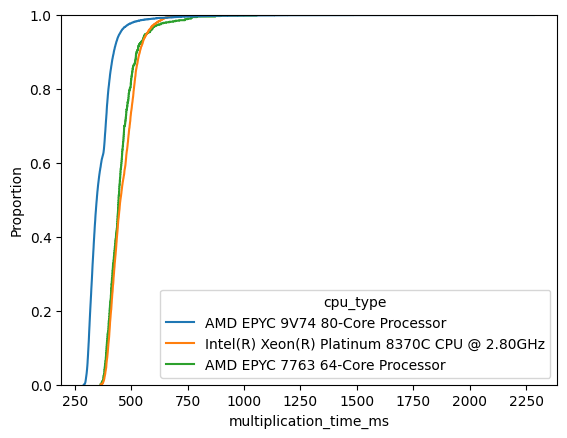

In [6]:
import seaborn as sns

df_filtered = df[(df["provider"] == "azure") & (df["memory_size_mb"] == 2048) & (df["benchmark_type"] == "gemm")]

sns.ecdfplot(data=df_filtered, x="multiplication_time_ms", hue="cpu_type")

                                        uuid  new_container  invocation_count
19641   bf0bcc8f-3048-400d-b45a-21a839d44336              0                 2
19663   358d7548-1f01-4b2f-b871-8d02d2e94c05              0                 2
19677   83ba31f5-75fd-41ba-9689-c19a7385d988              0                 2
19678   f06582a0-6511-49f2-b5d5-6652bbfdc459              0                 2
19680   25d4d51e-5b29-4ebb-a98c-38b267851c97              0                 2
...                                      ...            ...               ...
195829  5d5017b7-1c96-492d-8104-e40f5898d609              0                 2
195830  899f0a57-4135-47e8-8ba6-3921f342884d              0                 2
195831  7a515aa9-3f03-4ca0-8982-b62ced51d0cd              0                 2
195832  8d0c1125-5557-48d2-bf9e-bca1a64b12ed              0                 2
195833  f10b3814-f753-41b3-b572-26f91f3ea6ea              0                 4

[14924 rows x 3 columns]
Plotting aws with 128MB: 18000 records

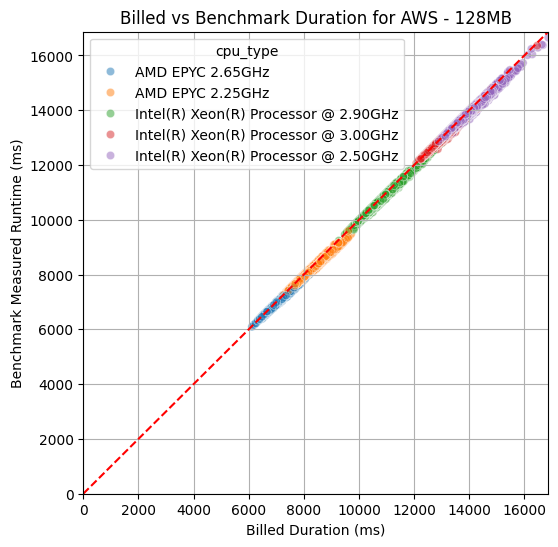

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_billed_vs_benchmark(provider, memory_size_mb):
    subset = df[(df["provider"] == provider) & (df["memory_size_mb"] == memory_size_mb) & (df["billed_duration_ms"].notnull())]

    # print id of records that have no new container but invocation count 1
    no_new_container = subset[(subset["new_container"] == 0)]
    print(no_new_container[["uuid", "new_container", "invocation_count"]])

    print(f"Plotting {provider} with {memory_size_mb}MB: {len(subset)} records")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        data=subset,
        x="billed_duration_ms",
        y="runtime_ms",
        hue="cpu_type",
        alpha=0.5,
    )

    max_val = max(subset["billed_duration_ms"].max(), subset["runtime_ms"].max())
    plt.plot([0, max_val], [0, max_val], color="red", linestyle="--")
    plt.title(f"Billed vs Benchmark Duration for {provider.upper()} - {memory_size_mb}MB")
    plt.xlabel("Billed Duration (ms)")
    plt.ylabel("Benchmark Measured Runtime (ms)")
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.grid(True)
    plt.show()

# Example usage:
plot_billed_vs_benchmark("aws", 128)

In [4]:
from helpers.cpus import clean_cpu_string, shorten_cpu_name, get_cpu_palette
from helpers.benchmark import metric_for_benchmark

def filter_stage_cpu_data(df, provider, memory_size=512, region=None, benchmark="gemm", filter_on_timestamp=False):
    """
    Your original filtering logic with CPU normalization added.
    
    Filtering steps:
    1. Provider, memory size, benchmark, region filtering
    2. CPU name normalization
    3. Complete groups (4 invocations + 1 new_container)
    4. Tukey outlier removal
    5. Warm invocations only (invocation_count > 1)
    """

    # --- 1. Filter relevant subset ---
    df_filtered = df[
        (df["provider"] == provider) &
        (df["memory_size_mb"] == memory_size) &
        (df["benchmark_type"] == benchmark) & 
        ((region is None) | (df["region"] == region))
    ].copy()
    
    print(f"After basic filter: {len(df_filtered):,} records")
    
    if df_filtered.empty:
        print("❌ No data after basic filtering")
        return df_filtered
    
    # --- 2. CPU Name Normalization (NEW) ---
    df_filtered["cpu_type"] = df_filtered["cpu_type"].apply(clean_cpu_string)
    
    # --- 3. Complete Groups Filter ---
    # Only keep instances with all 4 invocations
    grouped = df_filtered.groupby("instance_id")
    valid_ids = [
        inst_id
        for inst_id, group in grouped
        if len(group) == 4
    ]
    
    df_filtered = df_filtered[df_filtered["instance_id"].isin(valid_ids)]
    print(f"After complete groups (4 inv + 1 new): {len(df_filtered):,} records")
    
    # --- 4. Tukey Outlier Filter ---
    metric = metric_for_benchmark(benchmark)
    df_filtered = df_filtered[df_filtered["invocation_count"] > 1]

    
    def is_outlier_tukey(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return (series < lower_bound) | (series > upper_bound)
    
    group_cols = ["cpu_type"] + (["timestamp"] if filter_on_timestamp else [])
    outlier_mask = df_filtered.groupby(group_cols)[metric].transform(is_outlier_tukey)
    bad_instances = df_filtered.loc[outlier_mask, "instance_id"].unique()
    df_filtered = df_filtered[~df_filtered["instance_id"].isin(bad_instances)]
    
    print(f"After Tukey outlier removal: {len(df_filtered):,} records")
    
    
    print(f"After warm-only filter: {len(df_filtered):,} records")
    print(f"Unique CPUs: {df_filtered['cpu_type'].nunique()}")
    print(f"Unique instances: {df_filtered['instance_id'].nunique()}")
    
    return df_filtered


💾 Saved to: plots/stage_b/stage_b_cpu_share.pdf


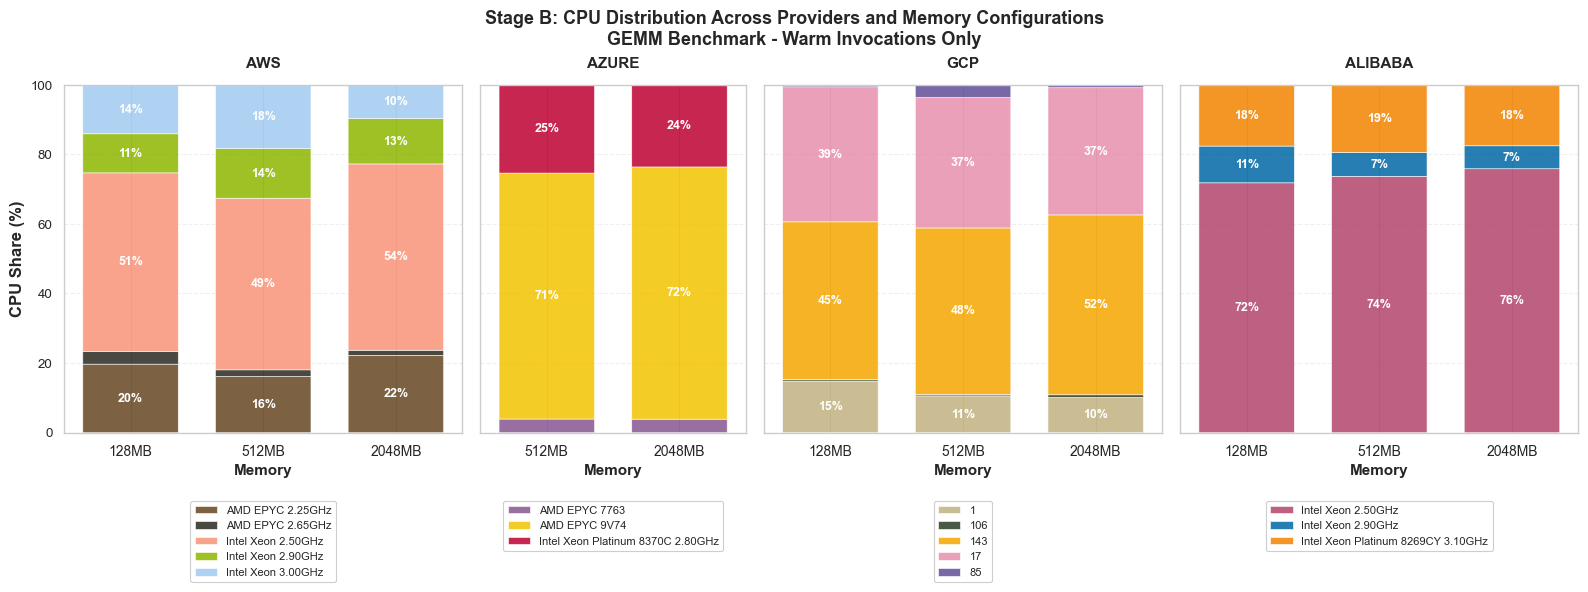

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import FancyBboxPatch
from helpers.cpus import shorten_cpu_name, get_cpu_color
from helpers.benchmark import filter_cpu_data

def plot_stage_b_cpu_share(df, save_dir="../holy/plots/StageB"):
    """
    Plot CPU share across all providers and memory configurations.
    
    Creates vertical stacked bars showing CPU distribution:
    - 4 subplots (one per provider)
    - X-axis: Memory configurations (128MB, 512MB, 2048MB)
    - Y-axis: CPU Share (%)
    - Colors: Different CPU types (provider-aware)
    """
    
    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    benchmark = "gemm"
    
    # Collect data for all configurations
    results = []
    
    for provider in providers:
        # Azure only has 512MB and 2048MB
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes
        
        for memory_size in provider_memory_sizes:
            df_filtered =  filter_cpu_data(
                df, 
                provider=provider, 
                memory_size=memory_size, 
                benchmark=benchmark, 
                group_on_timestamp=False, # As requested
                remove_cold=True          # As requested
            )
            
            if df_filtered.empty:
                print(f"⚠️  No data for {provider} {memory_size}MB")
                continue
            
            # Calculate CPU distribution
            cpu_counts = df_filtered.groupby("cpu_type").size()
            total = cpu_counts.sum()
            
            for cpu, count in cpu_counts.items():
                results.append({
                    "provider": provider,
                    "memory_size": memory_size,
                    "cpu_type": cpu,
                    "count": count,
                    "percentage": (count / total * 100)
                })
    
    results_df = pd.DataFrame(results)
    
    if results_df.empty:
        print("❌ No data to plot")
        return
    
    # Create figure with 4 subplots - Azure is 2/3 width
    fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True,
                            gridspec_kw={'width_ratios': [3, 2, 3, 3]})
    
    bar_width = 0.7
    
    for idx, provider in enumerate(providers):
        ax = axes[idx]
        
        # Azure only has 512MB and 2048MB
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes
        
        # Filter data for this provider
        provider_data = results_df[results_df["provider"] == provider]
        
        n_configs = len(provider_memory_sizes)
        x_positions = np.arange(n_configs)
        
        if provider_data.empty:
            ax.text(0.5, 0.5, f"No data", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xticks(x_positions)
            ax.set_xticklabels([f"{mem}MB" for mem in provider_memory_sizes], fontsize=10)
            ax.set_title(f"{provider.upper()}", fontweight='bold', fontsize=11, pad=12)
            continue
        
        # Get unique CPUs for this provider
        provider_cpus = sorted(provider_data["cpu_type"].unique())
        
        # Build pivot data - include ALL memory sizes for this provider
        pivot_data = {}
        for mem_size in provider_memory_sizes:
            mem_data = provider_data[provider_data["memory_size"] == mem_size]
            pivot_data[mem_size] = {
                row["cpu_type"]: row["percentage"]
                for _, row in mem_data.iterrows()
            }
        
        # Plot stacked bars with rounded corners
        bottom_positions = np.zeros(n_configs)
        legend_entries = {}
        
        for cpu_name in provider_cpus:
            heights = []
            
            for mem_size in provider_memory_sizes:
                heights.append(pivot_data[mem_size].get(cpu_name, 0))
            
            # Get color for this CPU with provider context
            color = get_cpu_color(cpu_name, provider=provider)
            
            # Draw rounded rectangles manually
            for i, height in enumerate(heights):
                if height > 0:
                    x_pos = x_positions[i] - bar_width/2
                    y_pos = bottom_positions[i]
                    
                    # Create rounded rectangle
                    fancy_box = FancyBboxPatch(
                        (x_pos, y_pos), bar_width, height,
                        boxstyle="round,pad=0.01",
                        edgecolor='white', facecolor=color,
                        linewidth=0.5, alpha=0.85,
                        transform=ax.transData
                    )
                    ax.add_patch(fancy_box)
                    
                    # Add percentage label
                    if height > 5:
                        ax.text(x_positions[i], y_pos + height/2, 
                               f'{height:.0f}%', 
                               ha='center', va='center', 
                               fontweight='bold', color='white', fontsize=9)
                    
                    # Add to legend (only once per CPU)
                    if cpu_name not in legend_entries:
                        cpu_label = shorten_cpu_name(cpu_name, 35)
                        legend_entries[cpu_name] = (fancy_box, cpu_label)
            
            bottom_positions += heights
        
        # Styling
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"{mem}MB" for mem in provider_memory_sizes], fontsize=10)
        ax.set_xlabel("Memory", fontweight='bold', fontsize=11)
        ax.set_ylim(0, 100)
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        
        # Tighter x-limits to squeeze bars together
        ax.set_xlim(-0.5, n_configs - 0.5)
        
        # Provider title with better padding
        ax.set_title(f"{provider.upper()}", fontweight='bold', fontsize=11, pad=12)
        
        # Add legend for this provider (below the plot)
        if legend_entries:
            handles = [entry[0] for entry in legend_entries.values()]
            labels = [entry[1] for entry in legend_entries.values()]
            ax.legend(handles, labels, 
                     loc='upper center', bbox_to_anchor=(0.5, -0.18), 
                     framealpha=0.95, fontsize=8, ncol=1)
    
    # Set y-axis label only on leftmost plot
    axes[0].set_ylabel("CPU Share (%)", fontweight='bold', fontsize=12)
    
    # Title with more spacing to avoid overlap
    fig.suptitle("Stage B: CPU Distribution Across Providers and Memory Configurations\n"
                 "GEMM Benchmark - Warm Invocations Only",
                 fontsize=13, fontweight='bold', y=0.985)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.86, bottom=0.28, wspace=0.05)
    
    # Save
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, "stage_b_cpu_share.pdf")
        plt.savefig(out_path, bbox_inches="tight", format='pdf')
        print(f"\n💾 Saved to: {out_path}")
    
    plt.show()


# Usage:
plot_stage_b_cpu_share(df, save_dir="plots/stage_b")

Processing Stage B Cost Plot (Filtered)...
No data found for azure - 128MB - gemm - region: None
Using duration column: multiplication_time_ms
💾 Saved to: ../holy/plots/StageB/stage_b_cost_comparison_filtered.pdf


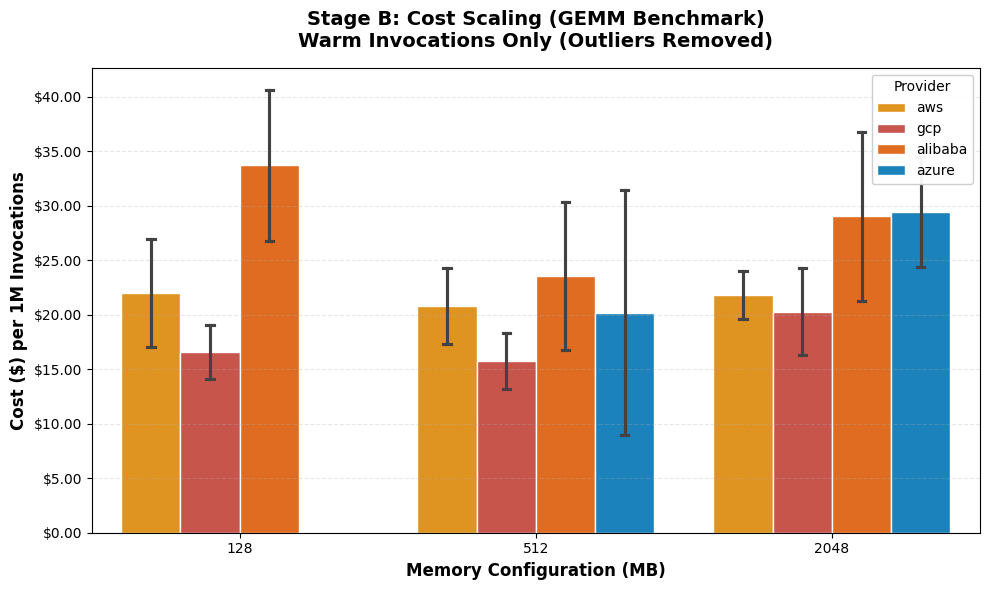

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import os

# --- IMPORT YOUR HELPER ---
from helpers.cost import calculate_cost
from helpers.benchmark import metric_for_benchmark
from helpers.benchmark import filter_cpu_data

def plot_stage_b_cost(df, save_dir="../holy/plots/StageB"):
    print("Processing Stage B Cost Plot (Filtered)...")
    
    providers = ["aws", "azure", "gcp", "alibaba"]
    memories = [128, 512, 2048]
    benchmark = "gemm"
    
    filtered_datasets = []

    # --- 1. Apply Strict Filtering Loop ---
    for provider in providers:
        for mem in memories:
            # Azure usually only has 512 and 2048, but filter_cpu_data handles this safely
            clean_df = filter_cpu_data(
                df, 
                provider=provider, 
                memory_size=mem, 
                benchmark=benchmark, 
                group_on_timestamp=False, # As requested
                remove_cold=True          # As requested
            )
            
            if not clean_df.empty:
                filtered_datasets.append(clean_df)

    if not filtered_datasets:
        print("❌ No data found after filtering.")
        return

    # Combine all clean chunks
    plot_df = pd.concat(filtered_datasets, ignore_index=True)
    
    # --- 2. Calculate Cost ---
    # Determine which column holds the duration
    metric_col = metric_for_benchmark(benchmark) # "multiplication_time_ms"
    if metric_col not in plot_df.columns:
        metric_col = "runtime_ms" # Fallback
    
    print(f"Using duration column: {metric_col}")

    plot_df["cost_usd"] = plot_df.apply(
        lambda row: calculate_cost(
            provider=row["provider"],
            memory_mb=row["memory_size_mb"],
            duration_ms=row[metric_col]
        ), axis=1
    )
    plot_df["cost_per_1m"] = plot_df["cost_usd"] * 1_000_000

    # --- 3. Plotting ---
    provider_colors = {
        "aws": "#FF9900", "azure": "#0089D6", 
        "gcp": "#DB4437", "alibaba": "#FF6600"
    }

    plt.figure(figsize=(10, 6))
    
    ax = sns.barplot(
        data=plot_df,
        x="memory_size_mb",
        y="cost_per_1m",
        hue="provider",
        palette=provider_colors,
        errorbar="sd", # Shows variance in cost (caused by performance variance)
        capsize=0.1,
        edgecolor="white",
        linewidth=1
    )

    ax.set_title("Stage B: Cost Scaling (GEMM Benchmark)\nWarm Invocations Only (Outliers Removed)", 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Memory Configuration (MB)", fontweight='bold', fontsize=12)
    ax.set_ylabel("Cost ($) per 1M Invocations", fontweight='bold', fontsize=12)
    
    fmt = '${x:,.2f}'
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.legend(title="Provider", loc='upper right', framealpha=0.95)

    plt.tight_layout()
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, "stage_b_cost_comparison_filtered.pdf")
        plt.savefig(out_path, bbox_inches="tight", format='pdf')
        print(f"💾 Saved to: {out_path}")
        
    plt.show()

# Run it
# plot_stage_b_cost(df)
# Usage:
plot_stage_b_cost(df)


💾 Saved to: plots/stage_b/stage_b_relative_to_config_mean_black_labels.pdf


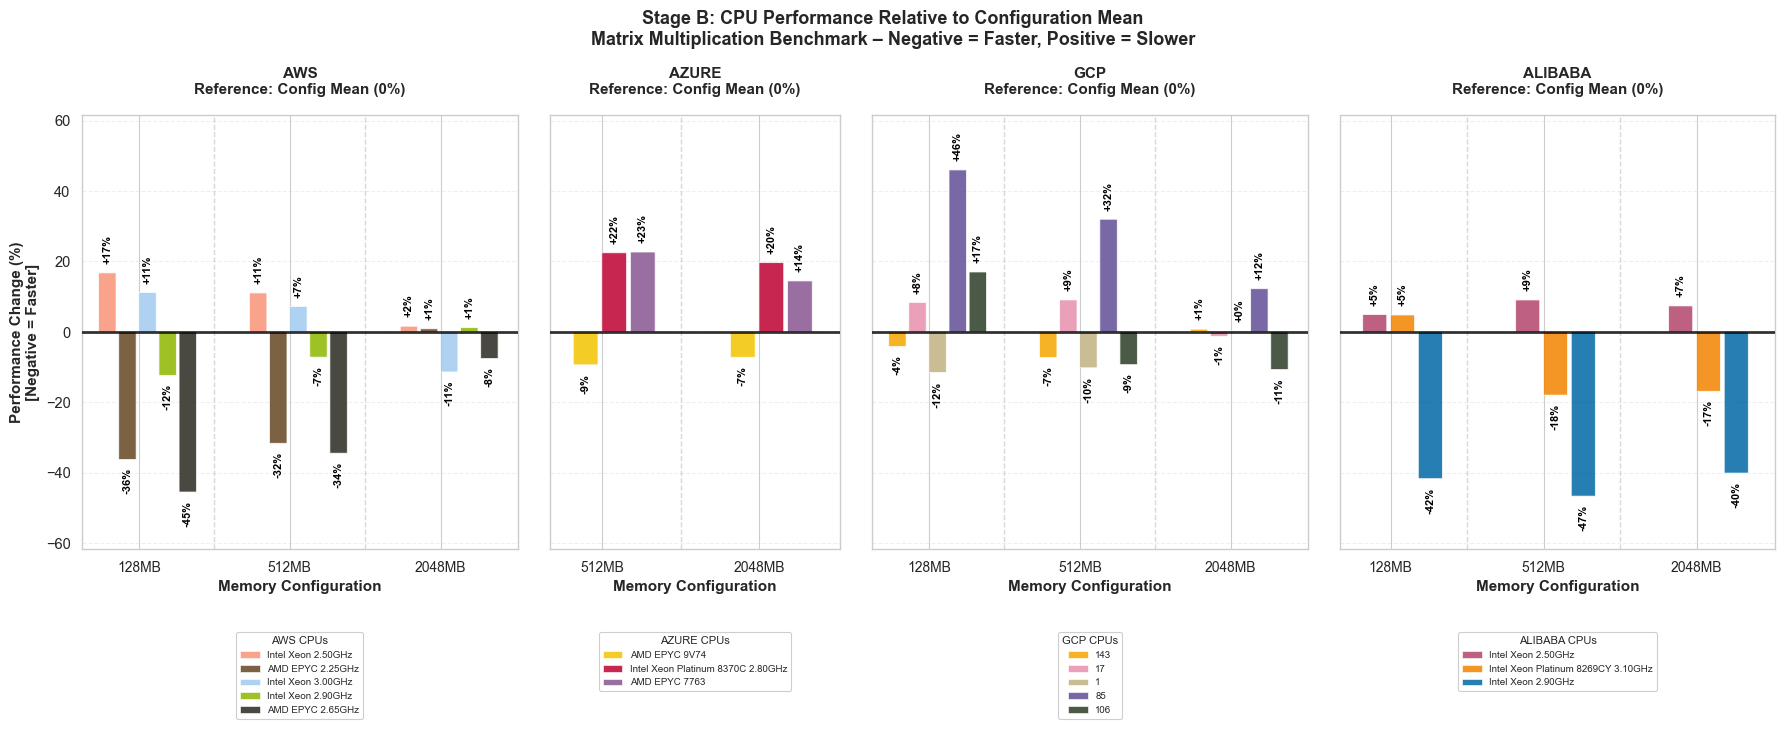

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle

from helpers.benchmark import filter_cpu_data, metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_color


def plot_stage_b_speedup_vs_config_mean(df, save_dir="../holy/plots/StageB"):
    """
    Stage B: CPU performance relative to the CONFIG MEAN for each (provider, memory) configuration.

    Fixes:
      1) Stable CPU order per provider (no re-sorting per memory config).
      2) All percentage labels are black and OUTSIDE the bars.

    Interpretation:
      - 0%  = equals config mean
      - <0% = faster than config mean (lower time)
      - >0% = slower than config mean (higher time)

    Uses per-instance warm mean as the analysis unit.
    """

    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    benchmark = "gemm"
    metric = metric_for_benchmark(benchmark)  # e.g. "multiplication_time_ms"

    fig, axes = plt.subplots(
        1, 4, figsize=(18, 7), sharey=True,
        gridspec_kw={"width_ratios": [3, 2, 3, 3]}
    )

    global_changes = []

    for idx, provider in enumerate(providers):
        ax = axes[idx]
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes

        # --- Load & filter per configuration ---
        provider_data_by_config = {}
        combined_parts = []

        for memory_size in provider_memory_sizes:
            df_filtered = filter_cpu_data(
                df=df,
                provider=provider,
                memory_size=memory_size,
                benchmark=benchmark,
                group_on_timestamp=False,
                remove_cold=True,
            )

            if not df_filtered.empty and metric in df_filtered.columns:
                df_filtered = df_filtered.dropna(subset=["cpu_type", "instance_id", metric, "region"])
                if not df_filtered.empty:
                    provider_data_by_config[memory_size] = df_filtered
                    combined_parts.append(df_filtered)

        if not combined_parts:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes, fontsize=12)
            ax.set_title(f"{provider.upper()}", fontweight="bold", fontsize=11, pad=15)
            ax.axis("off")
            continue

        combined_df = pd.concat(combined_parts, ignore_index=True)

        # --- Stable CPU order for this provider (by overall instance frequency) ---
        # This ensures CPU bar order doesn't change across memory configs.
        provider_cpu_order = (
            combined_df.groupby("cpu_type")["instance_id"]
            .nunique()
            .sort_values(ascending=False)
            .index
            .tolist()
        )

        # --- Compute pct_change per config ---
        all_plot_data = {}

        for memory_size in provider_memory_sizes:
            if memory_size not in provider_data_by_config:
                all_plot_data[memory_size] = {}
                continue

            df_config = provider_data_by_config[memory_size]

            # per-instance warm mean
            inst_means = (
                df_config
                .groupby(["cpu_type", "instance_id"], as_index=False)[metric]
                .mean()
                .rename(columns={metric: "inst_mean"})
            )
            overall_mean = inst_means["inst_mean"].mean()

            if not pd.notna(overall_mean) or overall_mean <= 0:
                all_plot_data[memory_size] = {}
                continue

            cpu_means = inst_means.groupby("cpu_type")["inst_mean"].mean()

            # store in dict cpu -> pct_change (stable order applied later)
            pct_map = {}
            for cpu, cpu_mean in cpu_means.items():
                pct_map[cpu] = (cpu_mean - overall_mean) / overall_mean * 100.0

            all_plot_data[memory_size] = pct_map

        # --- Layout: compute bar positions (stable CPU order) ---
        bar_width = 0.6
        config_gap = 1.5
        current_x = 0.0

        config_centers = []
        bar_positions = []

        for memory_size in provider_memory_sizes:
            pct_map = all_plot_data.get(memory_size, {})

            # keep stable order; only include CPUs present in this config
            cpus_in_config = [cpu for cpu in provider_cpu_order if cpu in pct_map]

            if not cpus_in_config:
                config_centers.append(current_x)
                current_x += config_gap
                continue

            n_bars = len(cpus_in_config)
            config_start = current_x

            for bar_idx, cpu in enumerate(cpus_in_config):
                x_pos = config_start + bar_idx * bar_width
                bar_positions.append({
                    "x": x_pos,
                    "memory_size": memory_size,
                    "cpu": cpu,
                    "pct_change": float(pct_map[cpu]),
                })

            config_center = config_start + (n_bars - 1) * bar_width / 2
            config_centers.append(config_center)

            current_x = config_start + n_bars * bar_width + config_gap

        # --- Plot bars + outside black labels ---
        for bd in bar_positions:
            x_pos = bd["x"]
            pct_change = bd["pct_change"]
            cpu = bd["cpu"]

            color = get_cpu_color(cpu, provider=provider)
            bar_w = bar_width * 0.85

            if pct_change < 0:
                patch = FancyBboxPatch(
                    (x_pos, pct_change), bar_w, -pct_change,
                    boxstyle="round,pad=0.005",
                    edgecolor="white",
                    facecolor=color,
                    linewidth=0.6,
                    alpha=0.85,
                    transform=ax.transData
                )
            else:
                patch = FancyBboxPatch(
                    (x_pos, 0), bar_w, pct_change,
                    boxstyle="round,pad=0.005",
                    edgecolor="white",
                    facecolor=color,
                    linewidth=0.6,
                    alpha=0.85,
                    transform=ax.transData
                )
            ax.add_patch(patch)

            # Always label outside, black
            # Use an offset relative to overall magnitude (keeps readable across providers)
            max_for_offset = max(10.0, abs(pct_change))
            offset = 2.5  # fixed offset in %-points works well here

            if pct_change >= 0:
                label_y = pct_change + offset
                va = "bottom"
            else:
                label_y = pct_change - offset
                va = "top"

            # Show labels for all bars (or gate with abs(pct_change) >= 1 if you want)
            ax.text(
                x_pos + bar_w / 2,
                label_y,
                f"{pct_change:+.0f}%",
                ha="center",
                va=va,
                fontsize=8,
                fontweight="bold",
                color="black",
                rotation=90,
                clip_on=False,
                zorder=20
            )

            global_changes.append(pct_change)

        # separators
        for mem_idx in range(len(provider_memory_sizes) - 1):
            if mem_idx < len(config_centers) - 1:
                sep_x = (config_centers[mem_idx] + config_centers[mem_idx + 1]) / 2
                ax.axvline(sep_x, color="gray", linestyle="--", linewidth=1, alpha=0.3, zorder=1)

        ax.axhline(0, color="black", linestyle="-", linewidth=2, alpha=0.8, zorder=10)

        if idx == 0:
            ax.set_ylabel("Performance Change (%)\n[Negative = Faster]", fontweight="bold", fontsize=11)

        ax.set_xticks(config_centers)
        ax.set_xticklabels([f"{mem}MB" for mem in provider_memory_sizes], fontsize=10)
        ax.set_xlabel("Memory Configuration", fontweight="bold", fontsize=11)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3, zorder=0)

        ax.set_title(
            f"{provider.upper()}\nReference: Config Mean (0%)",
            fontweight="bold",
            fontsize=11,
            pad=15
        )

        if bar_positions:
            ax.set_xlim(-0.5, max(b["x"] for b in bar_positions) + bar_width + 0.5)

        # Legend in stable order (provider_cpu_order)
        legend_handles, legend_labels = [], []
        for cpu in provider_cpu_order:
            c = get_cpu_color(cpu, provider=provider)
            legend_handles.append(Rectangle((0, 0), 1, 1, facecolor=c, edgecolor="white", linewidth=0.5, alpha=0.85))
            legend_labels.append(shorten_cpu_name(cpu, 30))

        ax.legend(
            legend_handles, legend_labels,
            loc="upper center", bbox_to_anchor=(0.5, -0.18),
            framealpha=0.95, fontsize=7, ncol=1,
            title=f"{provider.upper()} CPUs", title_fontsize=8
        )

    # Shared y-limits with padding for outside labels
    if global_changes:
        max_abs = max(abs(min(global_changes)), abs(max(global_changes)))
        pad = 8  # extra %-points for labels
        for ax in axes:
            ax.set_ylim(-(max_abs * 1.15 + pad), (max_abs * 1.15 + pad))

    fig.suptitle(
        "Stage B: CPU Performance Relative to Configuration Mean\n"
        "Matrix Multiplication Benchmark – Negative = Faster, Positive = Slower",
        fontsize=13, fontweight="bold", y=0.99
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.84, bottom=0.22, wspace=0.08)

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, "stage_b_relative_to_config_mean_black_labels.pdf")
        plt.savefig(out_path, bbox_inches="tight", format="pdf")
        print(f"\n💾 Saved to: {out_path}")

    plt.show()


# Usage:
plot_stage_b_speedup_vs_config_mean(df, save_dir="plots/stage_b")


In [26]:
import pandas as pd
import numpy as np

from helpers.benchmark import filter_cpu_data, metric_for_benchmark


def _cv_percent(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2:
        return np.nan
    m = x.mean()
    s = x.std(ddof=1)
    return (s / m * 100.0) if (pd.notna(m) and m > 0) else np.nan


def build_stage_b_cv_tables(
    df: pd.DataFrame,
    benchmark: str = "gemm",
    providers: list[str] = ["aws", "azure", "gcp", "alibaba"],
    memories: list[int] = [128, 512, 2048],
    min_instances_per_cell: int = 5,
    group_on_timestamp: bool = False,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      overall_df:  provider, memory_size_mb, n_instances, mean, std, cv
      cpu_df:      provider, memory_size_mb, cpu_type, n_instances, mean, std, cv

    CV is computed across per-instance warm means.
    """
    metric = metric_for_benchmark(benchmark)

    all_inst = []

    for provider in providers:
        for mem in memories:
            clean = filter_cpu_data(
                df=df,
                provider=provider,
                memory_size=mem,
                benchmark=benchmark,
                group_on_timestamp=group_on_timestamp,
                remove_cold=True,
            )
            if clean.empty or metric not in clean.columns:
                continue

            clean = clean.dropna(subset=["instance_id", "cpu_type", metric])

            # per-instance warm mean = one sample per instance
            inst = (
                clean.groupby(["provider", "memory_size_mb", "cpu_type", "instance_id"], as_index=False)[metric]
                .mean()
                .rename(columns={metric: "inst_warm_mean"})
            )
            all_inst.append(inst)

    if not all_inst:
        return (
            pd.DataFrame(columns=["provider", "memory_size_mb", "n_instances", "mean", "std", "cv"]),
            pd.DataFrame(columns=["provider", "memory_size_mb", "cpu_type", "n_instances", "mean", "std", "cv"]),
        )

    inst_df = pd.concat(all_inst, ignore_index=True)

    # Overall CV per provider x memory (pooling all CPUs)
    overall_df = (
        inst_df.groupby(["provider", "memory_size_mb"])["inst_warm_mean"]
        .agg(
            n_instances="count",
            mean="mean",
            std=lambda x: x.std(ddof=1),
            cv=_cv_percent,
        )
        .reset_index()
    )

    # Within-CPU CV per provider x memory x cpu
    cpu_df = (
        inst_df.groupby(["provider", "memory_size_mb", "cpu_type"])["inst_warm_mean"]
        .agg(
            n_instances="count",
            mean="mean",
            std=lambda x: x.std(ddof=1),
            cv=_cv_percent,
        )
        .reset_index()
    )

    # Optional: drop cells with too few instances (stabilizes CV)
    if min_instances_per_cell is not None and min_instances_per_cell > 1:
        cpu_df.loc[cpu_df["n_instances"] < min_instances_per_cell, ["cv", "std"]] = np.nan

    # Sort (CPU by name)
    overall_df = overall_df.sort_values(["provider", "memory_size_mb"])
    cpu_df = cpu_df.sort_values(["provider", "memory_size_mb", "cpu_type"])

    return overall_df, cpu_df


# Usage
overall_cv_df, cpu_cv_df = build_stage_b_cv_tables(df, benchmark="gemm")
overall_cv_df, cpu_cv_df


No data found for azure - 128MB - gemm - region: None


(   provider  memory_size_mb  n_instances          mean          std         cv
 0   alibaba             128         3147  14131.930356  2715.478756  19.215201
 1   alibaba             512         3738   2460.996676   662.644930  26.925877
 2   alibaba            2048         3620    760.258135   162.672107  21.396957
 3       aws             128         3249  10468.521553  2385.252509  22.784999
 4       aws             512         3602   2470.763415   410.533400  16.615650
 5       aws            2048         3528    647.962909    30.824928   4.757206
 6     azure             512         3897   1079.985112   566.911356  52.492516
 7     azure            2048         3787    394.615417    54.004986  13.685473
 8       gcp             128         3003   6939.109356   966.266781  13.924940
 9       gcp             512         3656   1599.066439   247.739690  15.492770
 10      gcp            2048         4173    634.358005   112.577844  17.746737,
    provider  memory_size_mb           

No data found for azure - 128MB - gemm - region: None
Saved: plots/stage_b/stage_b_cv_within_cpu_plus_overall_hatched.pdf


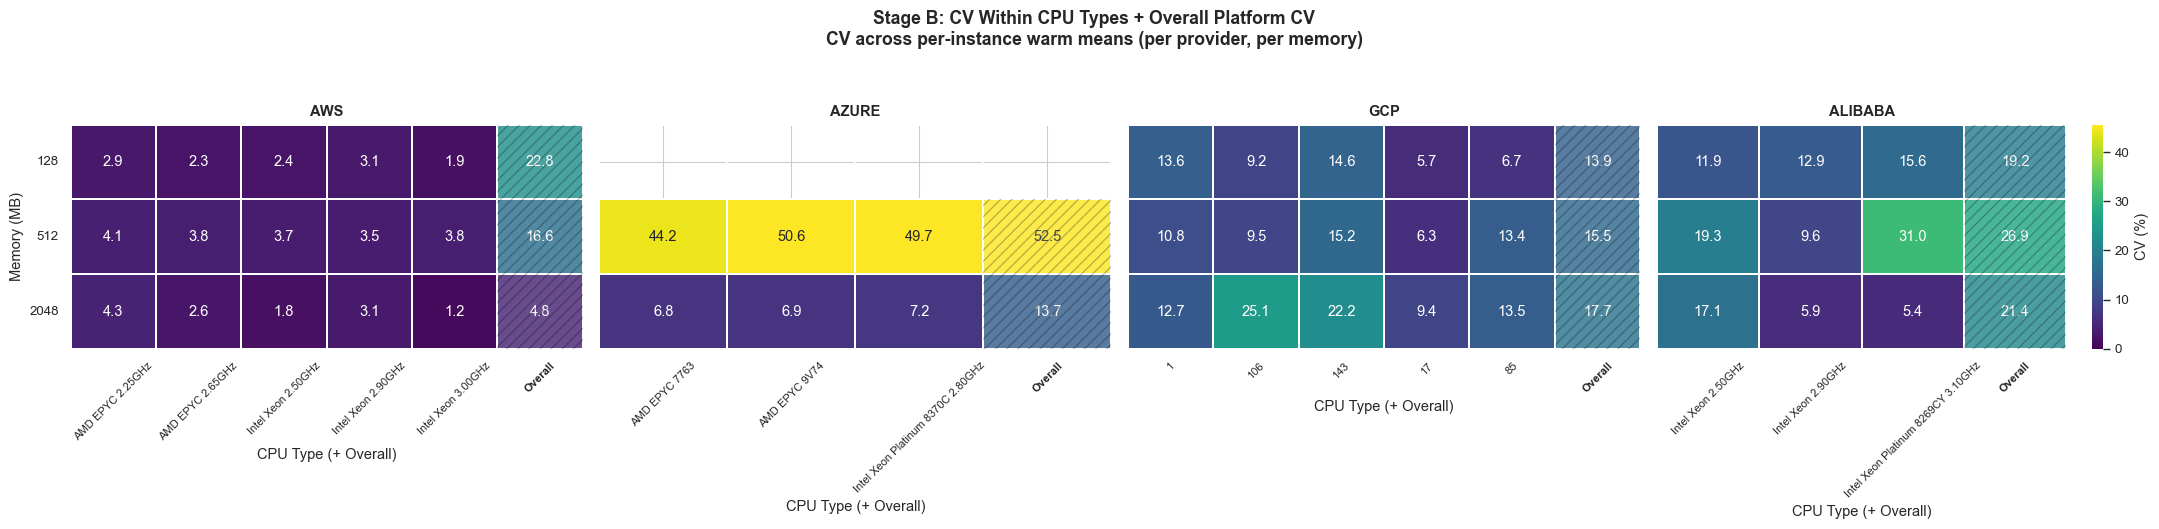

In [40]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from helpers.cpus import shorten_cpu_name

sns.set_theme(style="whitegrid", context="paper", font_scale=1.1)


def plot_stage_b_cv_heatmaps_overall_hatched(
    overall_cv_df: pd.DataFrame,
    cpu_cv_df: pd.DataFrame,
    providers: list[str] = ["aws", "azure", "gcp", "alibaba"],
    memories: list[int] = [128, 512, 2048],
    save_dir: str = "../holy/plots/StageB",
    filename: str = "stage_b_cv_within_cpu_plus_overall_hatched.pdf",
    hatch: str = "///",
    hatch_alpha: float = 0.18,   # subtle
):
    """
    One heatmap per provider.
    Adds Overall column and highlights it with a subtle hatched overlay (no border).
    """

    if cpu_cv_df.empty:
        print("No within-CPU CV data to plot.")
        return

    os.makedirs(save_dir, exist_ok=True)

    # Shared color scale (robust)
    vals = []
    if cpu_cv_df["cv"].notna().any():
        vals.append(cpu_cv_df["cv"].values)
    if overall_cv_df is not None and not overall_cv_df.empty and overall_cv_df["cv"].notna().any():
        vals.append(overall_cv_df["cv"].values)

    if vals:
        all_cv = np.concatenate([v[~np.isnan(v)] for v in vals])
        vmax = float(np.nanpercentile(all_cv, 95)) if len(all_cv) else 1.0
        vmax = max(vmax, 1.0)
    else:
        vmax = 1.0
    vmin = 0.0

    n = len(providers)
    fig, axes = plt.subplots(1, n, figsize=(5.5 * n, 5.0), sharey=True)
    if n == 1:
        axes = [axes]

    for i, provider in enumerate(providers):
        ax = axes[i]

        sub_cpu = cpu_cv_df[cpu_cv_df["provider"] == provider].copy()
        if sub_cpu.empty:
            ax.axis("off")
            ax.set_title(provider.upper())
            continue

        pivot = (
            sub_cpu.pivot_table(index="memory_size_mb", columns="cpu_type", values="cv", aggfunc="mean")
            .reindex(index=memories)
        )

        # Append Overall column
        if overall_cv_df is not None and not overall_cv_df.empty:
            sub_overall = overall_cv_df[overall_cv_df["provider"] == provider][["memory_size_mb", "cv"]].copy()
            overall_series = sub_overall.set_index("memory_size_mb")["cv"].reindex(memories)
            pivot["Overall"] = overall_series

        # Shorten CPU labels, keep Overall
        cols = []
        for c in pivot.columns:
            cols.append("Overall" if c == "Overall" else shorten_cpu_name(str(c), 18))
        pivot.columns = cols

        # Ensure Overall last
        if "Overall" in pivot.columns:
            cols = [c for c in pivot.columns if c != "Overall"] + ["Overall"]
            pivot = pivot[cols]

        sns.heatmap(
            pivot,
            ax=ax,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=".1f",
            linewidths=0.3,
            linecolor="white",
            cbar=(i == n - 1),
            cbar_kws={"label": "CV (%)"},
        )

        # --- Hatch overlay for Overall cells (only where value is not NaN) ---
        if "Overall" in pivot.columns:
            j = list(pivot.columns).index("Overall")  # column index
            for r in range(pivot.shape[0]):
                val = pivot.iloc[r, j]
                if pd.isna(val):
                    continue

                # One cell is 1x1 in heatmap coords: (col, row)
                ax.add_patch(
                    Rectangle(
                        (j, r),
                        1,
                        1,
                        fill=True,
                        facecolor=(1, 1, 1, hatch_alpha),  # subtle white tint
                        edgecolor=(0, 0, 0, 0.25),
                        linewidth=0.0,
                        hatch=hatch,
                        zorder=9,
                    )
                )

            # Bold tick label for "Overall"
            xticks = ax.get_xticklabels()
            for t in xticks:
                if t.get_text() == "Overall":
                    t.set_fontweight("bold")

        ax.set_title(provider.upper(), fontweight="bold")
        ax.set_xlabel("CPU Type (+ Overall)")
        ax.set_ylabel("Memory (MB)" if i == 0 else "")
        ax.tick_params(axis="x", rotation=45, labelsize=8)
        ax.tick_params(axis="y", rotation=0)

    fig.suptitle(
        "Stage B: CV Within CPU Types + Overall Platform CV\n"
        "CV across per-instance warm means (per provider, per memory)",
        y=1.05,
        fontweight="bold",
    )
    plt.tight_layout()

    out_path = os.path.join(save_dir, filename)
    plt.savefig(out_path, bbox_inches="tight")
    print(f"Saved: {out_path}")
    plt.show()
overall_cv_df, cpu_cv_df = build_stage_b_cv_tables(df, benchmark="gemm")
plot_stage_b_cv_heatmaps_overall_hatched(overall_cv_df, cpu_cv_df, save_dir="plots/stage_b")


<Axes: xlabel='multiplication_time_ms', ylabel='Proportion'>

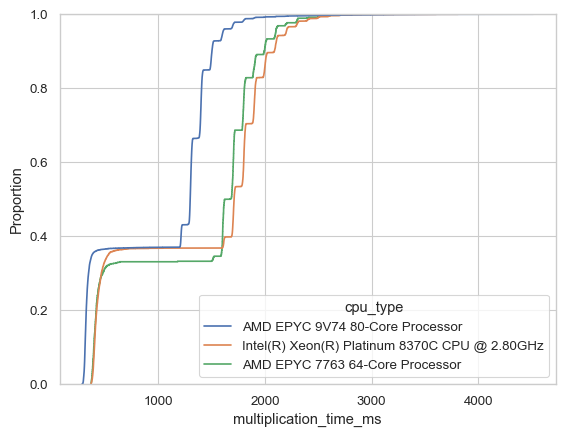

In [32]:
subset = df[(df["provider"] == "azure" ) & (df["memory_size_mb"] == 512) & (df["benchmark_type"] == "gemm")]


sns.ecdfplot(data=subset, x="multiplication_time_ms", hue="cpu_type")